In [2]:
import torch 
import torchvision 
import torchvision.models as models
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 

from torchvision import datasets, transforms 
from torchvision.datasets import CIFAR10 
from torch.utils.data import DataLoader 
from torch.optim import Adam 

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Data 

In [3]:
train_transform = transforms.Compose( 
    [
        transforms.Resize((224, 224)),   # Resize images to a fixed size
        transforms.ToTensor(),           # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.75,
                                 scale=(0.01, 0.3),
                                 ratio=(1.0, 1.0),
                                 value=0,
                                 inplace =True)        
    ])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to a fixed size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder('../data50/train', transform=train_transform)
test_dataset = datasets.ImageFolder('../data50/validation', transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Model

In [9]:
from torchsummary import summary 

vgg16 = models.vgg16()
f_extractor = vgg16.features 

model = nn.Sequential(f_extractor, 
                      nn.Flatten(), 
                      nn.Dropout(0.3), 
                      nn.Linear(512 * 7 * 7, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.3), 
                      nn.Linear(512, 2))

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

#### Train

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [11]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0 
    running_correct = 0 
    total = 0 
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
    
    accuracy = 100 * running_correct / total 
    test_loss = test_loss / len(test_loader)
    return test_loss, accuracy


In [12]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 50

In [13]:
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0 
    running_correct = 0 
    total = 0 

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs) 
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 *running_correct / total 
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


Epoch [1/50], Loss: 0.7440, Accuracy: 49.00%, Test Loss: 0.7042, Test Accuracy: 50.00
Epoch [2/50], Loss: 0.6968, Accuracy: 50.00%, Test Loss: 0.7045, Test Accuracy: 50.00
Epoch [3/50], Loss: 0.6955, Accuracy: 50.00%, Test Loss: 0.6982, Test Accuracy: 50.00
Epoch [4/50], Loss: 0.7007, Accuracy: 50.00%, Test Loss: 0.6952, Test Accuracy: 50.00
Epoch [5/50], Loss: 0.6913, Accuracy: 50.00%, Test Loss: 0.6939, Test Accuracy: 50.00
Epoch [6/50], Loss: 0.6948, Accuracy: 50.00%, Test Loss: 0.6934, Test Accuracy: 50.00
Epoch [7/50], Loss: 0.6900, Accuracy: 50.00%, Test Loss: 0.6930, Test Accuracy: 50.00
Epoch [8/50], Loss: 0.6890, Accuracy: 50.00%, Test Loss: 0.6944, Test Accuracy: 50.00
Epoch [9/50], Loss: 0.6562, Accuracy: 50.00%, Test Loss: 0.7073, Test Accuracy: 50.00
Epoch [10/50], Loss: 0.6650, Accuracy: 50.00%, Test Loss: 0.6981, Test Accuracy: 53.50
Epoch [11/50], Loss: 0.6564, Accuracy: 55.00%, Test Loss: 0.6938, Test Accuracy: 55.40
Epoch [12/50], Loss: 0.6541, Accuracy: 62.00%, Test 

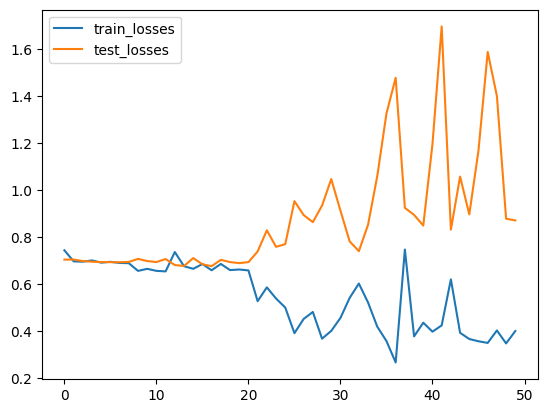

In [14]:
import matplotlib.pyplot as plt 

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

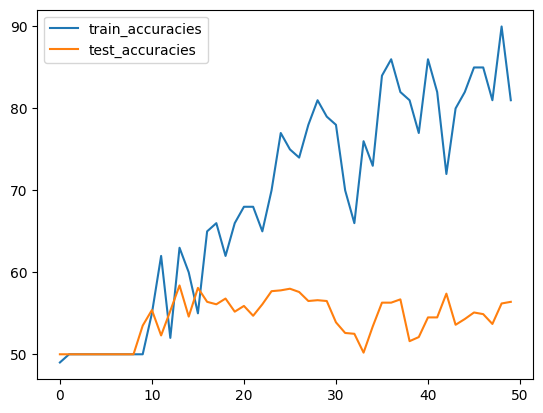

In [15]:
import matplotlib.pyplot as plt 

plt.plot(train_accuracies, label='train_accuracies')
plt.plot(test_accuracies, label='test_accuracies')
plt.legend()